In [1]:
using JuMP
using Ipopt
using DataFrames
import XLSX
using CSV
using Plots
gr(fmt=:png);

abstract type Model end
struct BEM <: Model end
struct Migration <: Model end

run = BEM();

In [2]:
df2 = dropmissing(DataFrame(XLSX.readtable("./DATA/PriceVolDataCorrected.xlsx", "Sheet1")...))
VolAll = Float64.(df2[:tons_DM][5:end]) ## CATCH DATA
PrAll = Float64.(df2[:priceMXNia_DM][5:end]) ## PRICE DATA

### New max time
time = df2[:Year][5]:0.1:df2[:Year][end]; #df2[:Year][5:end]
years = df2[:Year][5:end];
tmax = length(df2[:Year][5:end]);
(Cmax, CmaxIdx) = findmax(VolAll); # To calculate K. Should probably self reference this.

In [3]:
Th(a,b,c,d,t) = a+b*t+c*cos.(t)+d*sin.(t);
ddTh(c,d,t) = -c*cos.(t)-d*sin.(t);
function getMinT(a,b,c,d)
    t = 2*atan((sqrt(-b^2+c^2+d^2)+c)/(b-d))-2005; #dTh == 0, solve t
    if ddTh(c,d,t) > 0
        Th(a,b,c,d,t)
    else
        Th(a,b,c,d,t+π)
    end
end
function getMaxT(a,b,c,d, t)
    #t = 2*atan(b/c)+2005;
    2*atan((sqrt(-b^2+c^2+d^2)+c)/(b-d))
    if ddTh(c,d,t) < 0
        Th(a,b,c,d,t)
    else
        Th(a,b,c,d,t+π)
    end
end
#function getK(a,b,c,Cmax,idx)
#    taul = getMinTau(a,b,c);
#    tauu = getMaxTau(a,b,c);
#    Cmax*0.1*((tauh(a,b,c,idx)-taul)/(tauu-taul))
#end

In [4]:
#Initial isotherm coefficient guesses
b0 = -16.49; #mean depth
b1 = 0.02; #trend
b2 = 6.779; #amplitude
b3 = 0.091; #period of seasonal cycles


q = 0.1 #*maximum(Th(b0, b1, b2, b3, time)) Laura just sets this to 10% regardless of migration
τ = Th(b0, b1, b2, b3, (1:tmax)+2015) #rather than years to match laura's data
τn = ((τ-minimum(τ))/(maximum(τ)-minimum(τ)))
qt = 0.1*τn
K = 1208770 #Cmax*q Laura is hardcoding this too.

f = 40.0 # l of fuel per trip
m = 5_492_603.58 # cost per unit of transport all boats, MXN/trip
σ = m*f; # fleet cost of transport
c_t = 107291548; # cost of fishing

In [8]:
# Model with free effort
model = JuMP.Model(solver = IpoptSolver(print_level=3,max_iter=100000,print_frequency_iter=200,sb="yes"));

@variable(model, 0.0 <= β <= 1.0) # slope of demand-price function
@variable(model, 20_000.0 <= γₘ <= 51_000.0) # maximum demand, t
@variable(model, 0.0 <= g <= 3.2) # population growth rate
@variable(model, 1000.0 <= κ <= 2148.0) # cost of processing, MXNia/t

@variable(model, 0.0 <= E[t=1:tmax] <= 1.0) # fishing effort
@variable(model, p_f[t=1:tmax]) # price for fishers
@variable(model, S[t=1:tmax] >= 0.0) # size of the squid population 18000 , 1200000
@variable(model, C[t=1:tmax]  >= 0.0) # squid catch. Nominally ~10% of S, which comes through from 0.1*... in q
@variable(model, 4_000.0 <= p_m[t=1:tmax] <= 100_000.0) # export/market price

@variable(model, match)

@NLconstraint(model, [t=1:tmax-1], S[t+1] == S[t]+(g*S[t]*(1-(S[t]/K))-C[t]));
@NLconstraint(model, [t=1:tmax], p_m[t] == γₘ*(C[t])^(-β));
@constraint(model, [t=1:tmax], p_f[t] == p_m[t]-κ);
@NLconstraint(model, [t=1:tmax], C[t] == q*E[t]*S[t]);

@NLconstraint(model, match == sum(abs(p_f[t] - PrAll[t])^2+abs(C[t] - VolAll[t])^2 for t in 1:tmax));
@objective(model, Min, match);

In [9]:
solve(model)

Total number of variables............................:       65
                     variables with only lower bounds:       24
                variables with lower and upper bounds:       28
                     variables with only upper bounds:        0
Total number of equality constraints.................:       48
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 168

                                   (scaled)                 (unscaled)
Objective...............:   3.4460810746150278e+07    3.4460810746150278e+07
Dual infeasibility......:   1.8693608136961587e-08    1.8693608136961587e-08
Constraint violation....:   1.1641532182693481e-10    1.1641532182693481e-10
Complementarity.........:   9.2470679402514066e-10    9.2470679402514066e-10
Overall NLP 

:Optimal

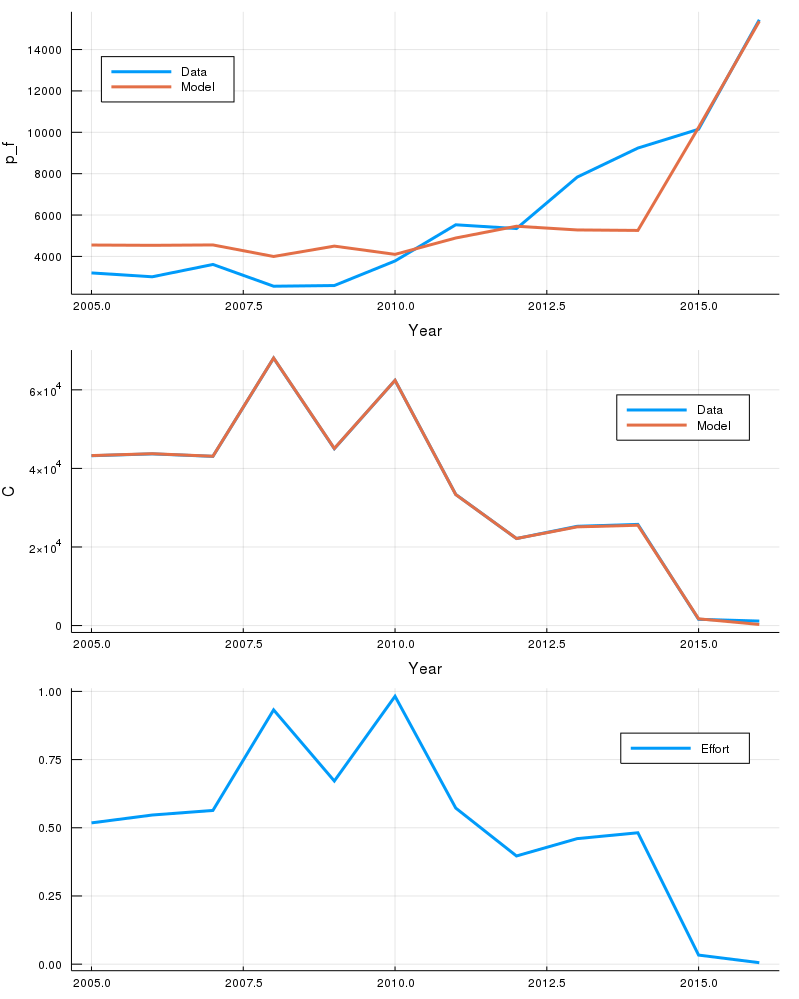

In [10]:
ha = plot(years, PrAll, xlabel="Year", ylabel="p_f", label="Data", legend=:topleft)
plot!(years, getvalue(p_f), label="Model")
hb = plot(years, VolAll, xlabel="Year", ylabel="C", label="Data")
plot!(years, getvalue(C), label="Model")
hc = plot(years, getvalue(E), label = "Effort")
plot(ha,hb,hc,linewidth=3,layout=(3,1),size=(800,1000))

This result is interesting to see, since it's quite intuative that this would be the optimal effort result:

$$C_t = qE_tS_t$$

where q is constant, E is some normaliser allows us to directly proportion C to S.

If we keep this parameter set, you can clearly see below that E = normalised C is the only functional form of E that makes sense.

In [26]:
# Model with Mechanistic effort (scaling free)
# NOTE: I have to cut this one short, it will never hit optimal.
modeln = JuMP.Model(solver = IpoptSolver(print_level=3,max_iter=1000,print_frequency_iter=200,sb="yes"));

@variable(modeln, 0.0 <= βn <= 1.0) # slope of demand-price function
@variable(modeln, 20_000.0 <= γₘn <= 51_000.0) # maximum demand, t
@variable(modeln, 0.0 <= gn <= 3.2) # population growth rate
@variable(modeln, 1000.0 <= κn <= 2148.0) # cost of processing, MXNia/t

@variable(modeln, En[t=1:tmax]) # fishing effort
@variable(modeln, p_fn[t=1:tmax]) # price for fishers
@variable(modeln, Sn[t=1:tmax] >= 0.0) # size of the squid population 18000 , 1200000
@variable(modeln, Cn[t=1:tmax]  >= 0.0) # squid catch. Nominally ~10% of S, which comes through from 0.1*... in q
@variable(modeln, 4_000.0 <= p_mn[t=1:tmax] <= 100_000.0) # export/market price

@variable(modeln, matchn)

@NLconstraint(modeln, [t=1:tmax-1], Sn[t+1] == Sn[t]+(gn*Sn[t]*(1-(Sn[t]/K))-Cn[t]));
@NLconstraint(modeln, [t=1:tmax], p_mn[t] == γₘn*(Cn[t])^(-βn));
@constraint(modeln, [t=1:tmax], p_fn[t] == p_mn[t]-κn);
@NLconstraint(modeln, [t=1:tmax], Cn[t] == q*En[t]*Sn[t]);
@NLconstraint(modeln, [t=1:tmax-1], En[t+1] == En[t]+(p_fn[t]*Cn[t]-σ*En[t]));

@NLconstraint(modeln, matchn == sum(abs(p_fn[t] - PrAll[t])^2+abs(Cn[t] - VolAll[t])^2 for t in 1:tmax));
@objective(modeln, Min, matchn);

In [27]:
solve(modeln)

Total number of variables............................:       65
                     variables with only lower bounds:       24
                variables with lower and upper bounds:       16
                     variables with only upper bounds:        0
Total number of equality constraints.................:       59
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 1000

                                   (scaled)                 (unscaled)
Objective...............:  -4.2007795447425148e+10   -4.2007795447425148e+10
Dual infeasibility......:   2.7587728904570156e+08    2.7587728904570156e+08
Constraint violation....:   3.1805013394670211e+07    4.3298465508833527e+10
Complementarity.........:   4.2654253166657754e+03    4.2654253166657754e+03
Overall NLP

:UserLimit

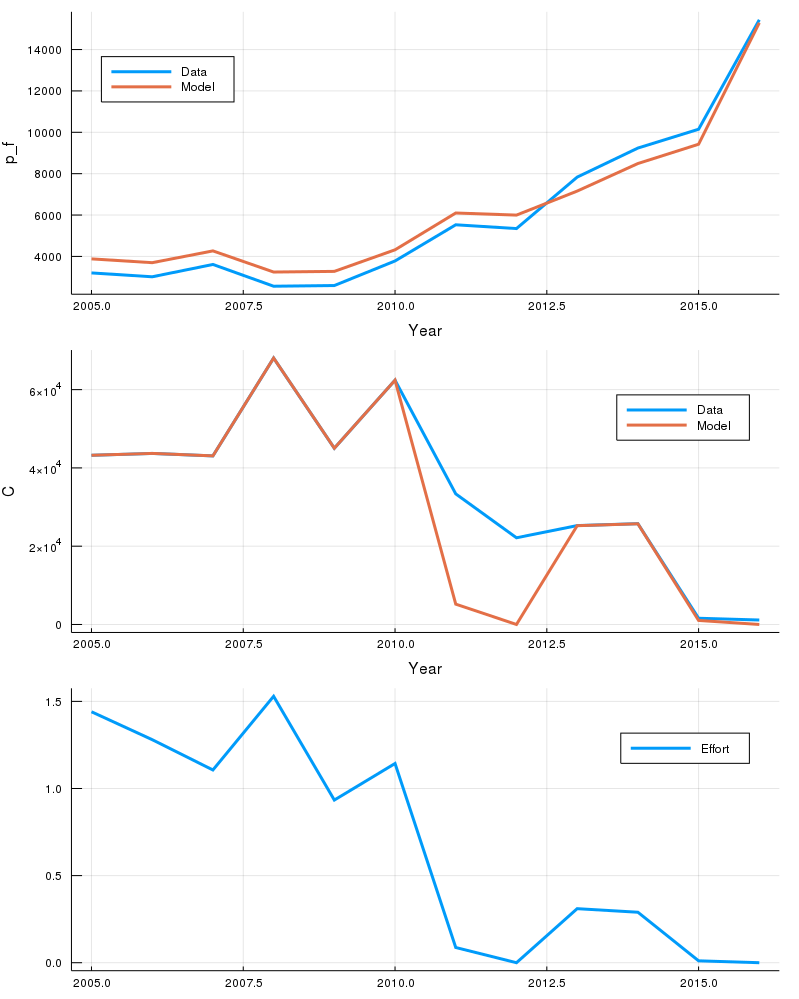

In [28]:
ha = plot(years, PrAll, xlabel="Year", ylabel="p_f", label="Data", legend=:topleft)
plot!(years, getvalue(p_fn), label="Model")
hb = plot(years, VolAll, xlabel="Year", ylabel="C", label="Data")
plot!(years, getvalue(Cn), label="Model")
hc = plot(years, getvalue(En), label = "Effort")
plot(ha,hb,hc,linewidth=3,layout=(3,1),size=(800,1000))

In [11]:
# Model with effort ≡ 1
modele = JuMP.Model(solver = IpoptSolver(print_level=3,max_iter=100000,print_frequency_iter=200,sb="yes"));

@variable(modele, 0.0 <= βe <= 1.0) # slope of demand-price function
@variable(modele, 20_000.0 <= γₘe <= 51_000.0) # maximum demand, t
@variable(modele, 0.0 <= ge <= 3.2) # population growth rate
@variable(modele, 1000.0 <= κe <= 2148.0) # cost of processing, MXNia/t

@variable(modele, p_fe[t=1:tmax]) # price for fishers
@variable(modele, Se[t=1:tmax] >= 0.0) # size of the squid population 18000 , 1200000
@variable(modele, Ce[t=1:tmax]  >= 0.0) # squid catch. Nominally ~10% of S, which comes through from 0.1*... in q
@variable(modele, 4_000.0 <= p_me[t=1:tmax] <= 100_000.0) # export/market price

@variable(modele, matche)
Ee = fill(1.0,tmax)

@NLconstraint(modele, [t=1:tmax-1], Se[t+1] == Se[t]+(ge*Se[t]*(1-(Se[t]/K))-Ce[t]));
@NLconstraint(modele, [t=1:tmax], p_me[t] == γₘe*(Ce[t])^(-βe));
@constraint(modele, [t=1:tmax], p_fe[t] == p_me[t]-κe);
@NLconstraint(modele, [t=1:tmax], Ce[t] == q*Ee[t]*Se[t]);

@NLconstraint(modele, matche == sum(abs(p_fe[t] - PrAll[t])^2+abs(Ce[t] - VolAll[t])^2 for t in 1:tmax));
@objective(modele, Min, matche);

In [12]:
solve(modele)

Total number of variables............................:       53
                     variables with only lower bounds:       24
                variables with lower and upper bounds:       16
                     variables with only upper bounds:        0
Total number of equality constraints.................:       48
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 78

                                   (scaled)                 (unscaled)
Objective...............:   2.6307394152462516e+09    2.6307394152462516e+09
Dual infeasibility......:   2.4967019859401321e-07    2.4967019859401321e-07
Constraint violation....:   3.5026211727140353e-10    4.7683715820312500e-07
Complementarity.........:   2.8476815931080915e-09    2.8476815931080915e-09
Overall NLP e

:Optimal

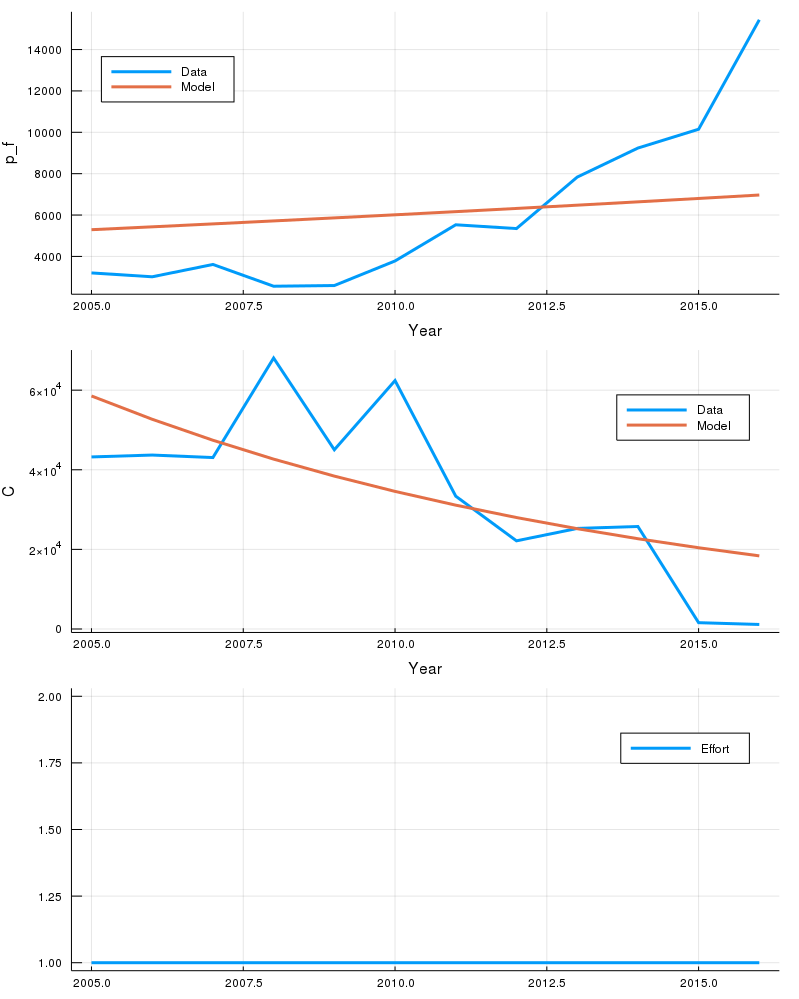

In [13]:
ha = plot(years, PrAll, xlabel="Year", ylabel="p_f", label="Data", legend=:topleft)
plot!(years, getvalue(p_fe), label="Model")
hb = plot(years, VolAll, xlabel="Year", ylabel="C", label="Data")
plot!(years, getvalue(Ce), label="Model")
hc = plot(years, Ee, label = "Effort")
plot(ha,hb,hc,linewidth=3,layout=(3,1),size=(800,1000))

In [14]:
# Model with Logistic effort (no scaling)
modell = JuMP.Model(solver = IpoptSolver(print_level=3,max_iter=100000,print_frequency_iter=200,sb="yes"));

@variable(modell, 0.0 <= βl <= 1.0) # slope of demand-price function
@variable(modell, 20_000.0 <= γₘl <= 51_000.0) # maximum demand, t
@variable(modell, 0.0 <= gl <= 3.2) # population growth rate
@variable(modell, 1000.0 <= κl <= 2148.0) # cost of processing, MXNia/t

@variable(modell, 0.0 <= El[t=1:tmax] <= 1.0) # fishing effort
@variable(modell, p_fl[t=1:tmax]) # price for fishers
@variable(modell, Sl[t=1:tmax] >= 0.0) # size of the squid population 18000 , 1200000
@variable(modell, Cl[t=1:tmax]  >= 0.0) # squid catch. Nominally ~10% of S, which comes through from 0.1*... in q
@variable(modell, 4_000.0 <= p_ml[t=1:tmax] <= 100_000.0) # export/market price
@variable(modell, RF[t=1:tmax]) #Revenue for fishers

@variable(modell, matchl)

@NLconstraint(modell, [t=1:tmax-1], Sl[t+1] == Sl[t]+(gl*Sl[t]*(1-(Sl[t]/K))-Cl[t]));
@NLconstraint(modell, [t=1:tmax], p_ml[t] == γₘl*(Cl[t])^(-βl));
@constraint(modell, [t=1:tmax], p_fl[t] == p_ml[t]-κl);
@NLconstraint(modell, [t=1:tmax], Cl[t] == q*El[t]*Sl[t]);
@NLconstraint(modell, [t=1:tmax-1], El[t+1] == 0.5+1/(1+exp(-RF[t]/17622692)*100));
@constraint(modell, [t=1:tmax], RF[t] == Cl[t]*p_fl[t]-c_t*El[t]);

@NLconstraint(modell, matchl == sum(abs(p_fl[t] - PrAll[t])^2+abs(Cl[t] - VolAll[t])^2 for t in 1:tmax));
@objective(modell, Min, matchl);

In [15]:
solve(modell)

Total number of variables............................:       77
                     variables with only lower bounds:       24
                variables with lower and upper bounds:       28
                     variables with only upper bounds:        0
Total number of equality constraints.................:       71
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 1608

                                   (scaled)                 (unscaled)
Objective...............:   2.3713396536491265e+09    2.3713396536491265e+09
Dual infeasibility......:   5.2304395385059633e-06    5.2304395385059633e-06
Constraint violation....:   3.5026211727140353e-10    4.7683715820312500e-07
Complementarity.........:   3.3402014422456542e-09    3.3402014422456542e-09
Overall NLP

:Optimal

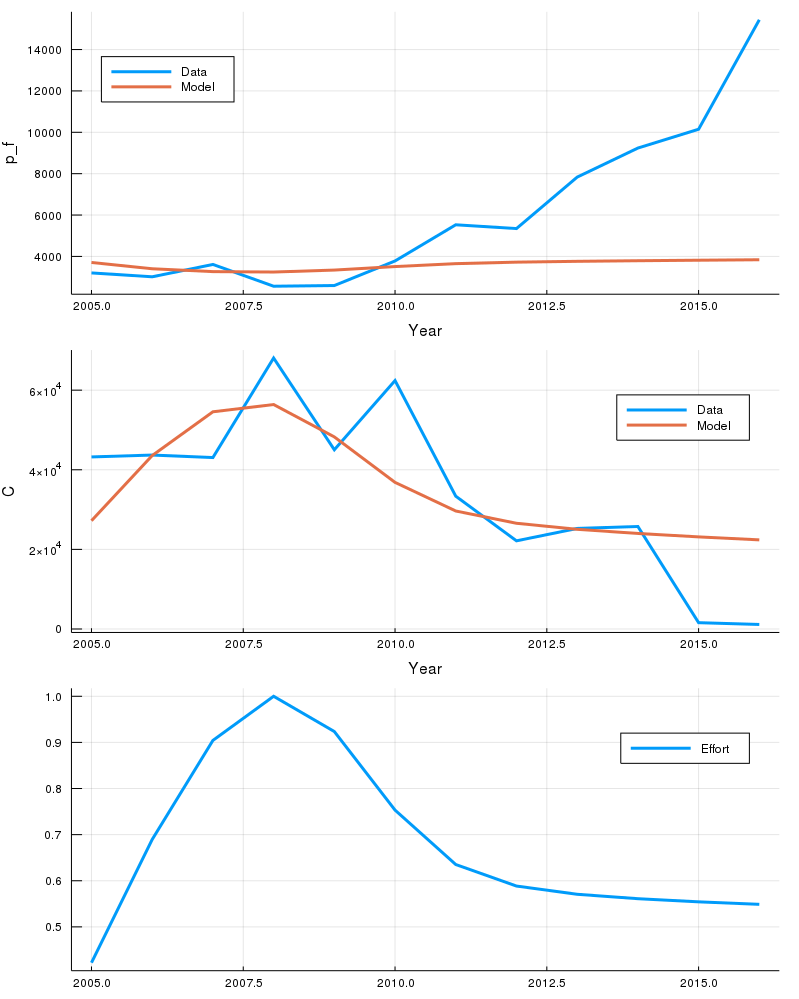

In [16]:
ha = plot(years, PrAll, xlabel="Year", ylabel="p_f", label="Data", legend=:topleft)
plot!(years, getvalue(p_fl), label="Model")
hb = plot(years, VolAll, xlabel="Year", ylabel="C", label="Data")
plot!(years, getvalue(Cl), label="Model")
hc = plot(years, getvalue(El), label = "Effort")
plot(ha,hb,hc,linewidth=3,layout=(3,1),size=(800,1000))

In [17]:
# Model with proportional q effort (no scaling)
modelq = JuMP.Model(solver = IpoptSolver(print_level=3,max_iter=100000,print_frequency_iter=200,sb="yes"));

@variable(modelq, 0.0 <= βq <= 1.0) # slope of demand-price function
@variable(modelq, 20_000.0 <= γₘq <= 51_000.0) # maximum demand, t
@variable(modelq, 0.0 <= gq <= 3.2) # population growth rate
@variable(modelq, 1000.0 <= κq <= 2148.0) # cost of processing, MXNia/t
c_p = 1776.25 # cost of processing
#@variable(modelq, Eq[t=1:tmax]) # fishing effort
@variable(modelq, p_fq[t=1:tmax]) # price for fishers
@variable(modelq, Sq[t=1:tmax] >= 0.0) # size of the squid population 18000 , 1200000
@variable(modelq, Cq[t=1:tmax]  >= 0.0) # squid catch. Nominally ~10% of S, which comes through from 0.1*... in q
@variable(modelq, 4_000.0 <= p_mq[t=1:tmax] <= 100_000.0) # export/market price

@variable(modelq, matchq)
Eq = τn

@NLconstraint(modelq, [t=1:tmax-1], Sq[t+1] == Sq[t]+(gq*Sq[t]*(1-(Sq[t]/K))-Cq[t]));
@NLconstraint(modelq, [t=1:tmax], p_mq[t] == γₘq*(Cq[t])^(-βq));
@constraint(modelq, [t=1:tmax], p_fq[t] == p_mq[t]-c_p);
@NLconstraint(modelq, [t=1:tmax], Cq[t] == q*Eq[t]*Sq[t]);

@NLconstraint(modelq, matchq == sum(abs(p_fq[t] - PrAll[t])^2+abs(Cq[t] - VolAll[t])^2 for t in 1:tmax));
@objective(modelq, Min, matchq);

In [18]:
solve(modelq)

Total number of variables............................:       53
                     variables with only lower bounds:       24
                variables with lower and upper bounds:       16
                     variables with only upper bounds:        0
Total number of equality constraints.................:       48
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 147

                                   (scaled)                 (unscaled)
Objective...............:   1.0594018072419634e+10    1.0594018072419634e+10
Dual infeasibility......:   9.0231403393929344e+04    9.0231403393929344e+04
Constraint violation....:   1.1641532182693481e-10    1.1641532182693481e-10
Complementarity.........:   1.9417206197875826e-06    1.9417206197875826e-06
Overall NLP 

:Optimal

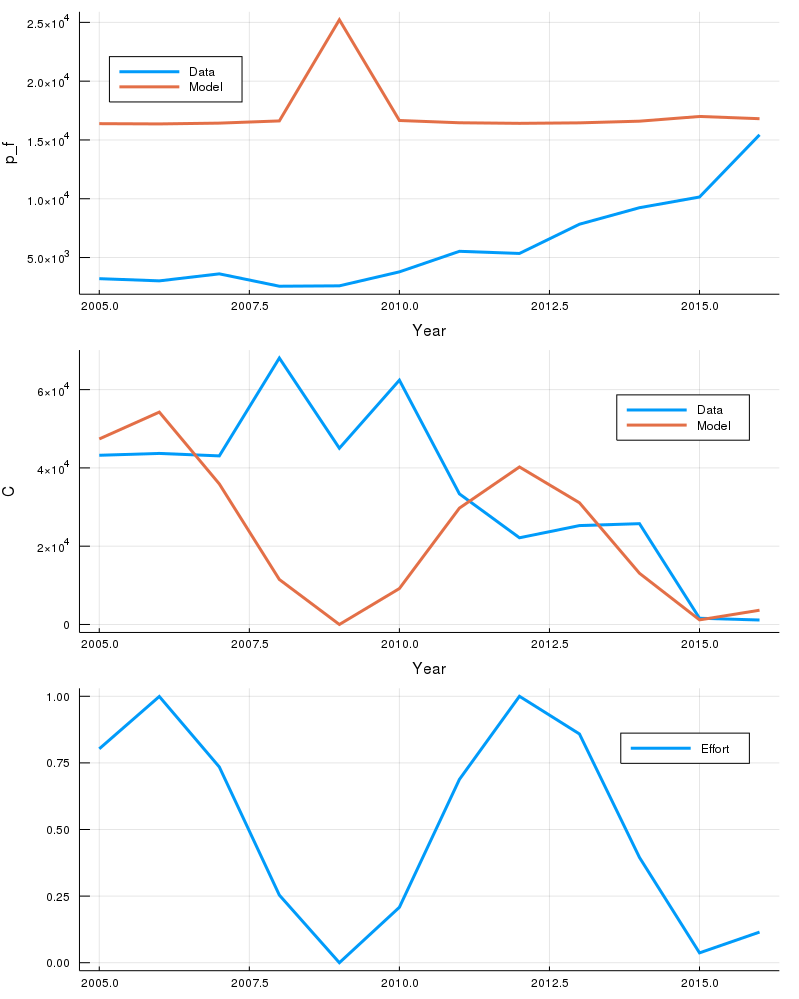

In [19]:
ha = plot(years, PrAll, xlabel="Year", ylabel="p_f", label="Data", legend=:topleft)
plot!(years, getvalue(p_fq), label="Model")
hb = plot(years, VolAll, xlabel="Year", ylabel="C", label="Data")
plot!(years, getvalue(Cq), label="Model")
hc = plot(years, Eq, label = "Effort")
plot(ha,hb,hc,linewidth=3,layout=(3,1),size=(800,1000))

----

Below here is yet to be updated. Ignore this region for the moment.

# Let's take the parameters from the initial run and plot E based on the captured parameters

In [ ]:
struct OptimalConstants
    β::Float64
    γ::Float64
    g::Float64
    κ::Float64
    E₀::Float64
    S₀::Float64
end

# Using initial optimal
r = OptimalConstants(getvalue(β), getvalue(γₘ), getvalue(g), getvalue(κ), getvalue(E)[1], getvalue(S)[1]);

# Discrete initially
Ed = Array{Float64}(length(years));
Ed[1] = r.E₀;
Sd = Array{Float64}(length(years));
Sd[1] = r.S₀;
Cd = Array{Float64}(length(years));
Cd[1] = q*r.E₀*r.S₀;
p_md = Array{Float64}(length(years));
p_md[1] = r.γ*Cd[1]^(-r.β);
p_fd = Array{Float64}(length(years));
p_fd[1] = p_md[1]-r.κ;

for t = 1:length(years)-1
    Sd[t+1] = Sd[t]+(r.g*Sd[t]*(1-(Sd[t]/K))-Cd[t]);
    Ed[t+1] = Ed[t]+(p_fd[t]*Cd[t]-σ*Ed[t]);
   
    Cd[t+1] = q*getvalue(E)[t+1]*Sd[t+1]; #Pull in the optimal value for Cd...
    p_md[t+1] = r.γ*Cd[t+1]^(-r.β);
    p_fd[t+1] = p_md[t+1]-r.κ;
end

# Total fail
Ed

In [ ]:
# Scaled
r = OptimalConstants(getvalue(βe), getvalue(γₘe), getvalue(ge), getvalue(κe), getvalue(Ee)[1], getvalue(Se)[1]);

Ed = Array{Float64}(length(years));
Ed[1] = r.E₀;
Sd = Array{Float64}(length(years));
Sd[1] = r.S₀;
Cd = Array{Float64}(length(years));
Cd[1] = q*r.E₀*r.S₀;
p_md = Array{Float64}(length(years));
p_md[1] = r.γ*Cd[1]^(-r.β);
p_fd = Array{Float64}(length(years));
p_fd[1] = p_md[1]-r.κ;

for t = 1:length(years)-1
    Sd[t+1] = Sd[t]+(r.g*Sd[t]*(1-(Sd[t]/K))-Cd[t]);
    Ed[t+1] = Ed[t]+(p_fd[t]*Cd[t]-σ*Ed[t]);
    
    Cd[t+1] = q*getvalue(Ee)[t+1]*Sd[t+1]; #Pull in the optimal value for Cd...
    p_md[t+1] = r.γ*Cd[t+1]^(-r.β);
    p_fd[t+1] = p_md[t+1]-r.κ;
end

# Total fail
Ed

In [ ]:
#Not scaled

r = OptimalConstants(getvalue(βn), getvalue(γₘn), getvalue(gn), getvalue(κn), getvalue(En)[1], getvalue(Sn)[1]);

Ed = Array{Float64}(length(years));
Ed[1] = r.E₀;
Sd = Array{Float64}(length(years));
Sd[1] = r.S₀;
Cd = Array{Float64}(length(years));
Cd[1] = q*r.E₀*r.S₀;
p_md = Array{Float64}(length(years));
p_md[1] = r.γ*Cd[1]^(-r.β);
p_fd = Array{Float64}(length(years));
p_fd[1] = p_md[1]-r.κ;

for t = 1:length(years)-1
    Sd[t+1] = Sd[t]+(r.g*Sd[t]*(1-(Sd[t]/K))-Cd[t]);
    Ed[t+1] = Ed[t]+(p_fd[t]*Cd[t]-σ*Ed[t]);
    
    Cd[t+1] = q*getvalue(En)[t+1]*Sd[t+1]; #Pull in the optimal value for Cd...
    p_md[t+1] = r.γ*Cd[t+1]^(-r.β);
    p_fd[t+1] = p_md[t+1]-r.κ;
end

#Total Fail
Ed

In [ ]:
log.(Ed-minimum(Ed))

Effort just doesn't seem feasible in this form at all. How is this the 'standard' model for this form of data?

---

Let's try a continuous method.

In [ ]:
using DifferentialEquations
# To work with optimal E
using Interpolations

In [ ]:
# Using initial optimal, trying to use E and failing
#p = [0.190159,  51000.0,  1.15065,  2148.0,  2.07596e5,  2.19704e8,  3.0498];
p = [getvalue(β), getvalue(γₘ), getvalue(g), getvalue(κ), K, σ, q];

function bem(out,du,u,p,t)
  out[1] = p[3]*u[1]*(1-(u[1]/p[5])) - u[3] - du[1] # S
  out[2] = u[5]*u[3]-p[6]*u[2] - du[2] # E
  out[3] = p[7]*u[2]*u[1] - u[3] # C
  out[4] = p[2]*u[3]^(-p[1]) - u[4] # p_m
  out[5] = u[4]-p[4] - u[5] # p_f  
end
S₀ = getvalue(S)[1];
#S₀ = 53773.30961941843;
E₀ = getvalue(E)[1];
#E₀ = 0.26381011097545004;

C₀ = p[7]*E₀*S₀;
p_m₀ = p[2]*C₀^(-p[1]);

u₀ = [S₀, E₀, C₀, p_m₀, p_m₀-p[4]];
du₀ = similar(u₀);
#tspan = (years[1],years[end]);
tspan = (2005.0,2016.0);
differential_vars = [true,true,false,false,false];

prob = DAEProblem(bem,du₀,u₀,tspan,p,differential_vars=differential_vars)

#sol = solve(prob,IDA())

In [ ]:
# Using initial optimal, using interpolated optimal E
#p = [0.190159,  51000.0,  1.15065,  2148.0,  2.07596e5,  2.19704e8,  3.0498];
p = [getvalue(β), getvalue(γₘ), getvalue(g), getvalue(κ), K, σ, q];

Econt = interpolate((years,), getvalue(E), Gridded(Linear()));

function bem(out,du,u,p,t)
  out[1] = p[3]*u[1]*(1-(u[1]/p[5])) - u[2] - du[1] # S
  #out[2] = u[5]*u[3]-p[6]*u[2] - du[2] # E
  out[2] = p[7]*Econt(t)*u[1] - u[2] # C
  out[3] = p[2]*u[2]^(-p[1]) - u[3] # p_m
  out[4] = u[3]-p[4] - u[4] # p_f  
end
S₀ = getvalue(S)[1];
#S₀ = 53773.30961941843;
#E₀ = getvalue(E)[1];
#E₀ = 0.26381011097545004;

C₀ = p[7]*Econt(years[1])*S₀;
p_m₀ = p[2]*C₀^(-p[1]);

u₀ = [S₀, C₀, p_m₀, p_m₀-p[4]];
du₀ = similar(u₀);
#tspan = (years[1],years[end]);
tspan = (2005.0,2016.0);
differential_vars = [true,false,false,false];

prob = DAEProblem(bem,du₀,u₀,tspan,p,differential_vars=differential_vars)

#sol = solve(prob,IDA())

In [ ]:
sol = DifferentialEquations.solve(prob,IDA())

In [ ]:
plot(sol, layout=(2,2), size=(800,600), label = ["S" "C" "p_m" "p_f"])